### Import libraries

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Load data

In [54]:
Breast_cancer = pd.read_csv('breast-cancer.data',header=None,names=['Class','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat'])

Check the first few rows of the dataset to check that we the correct data

In [55]:
Breast_cancer.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


check number of rows and columns

In [56]:
Breast_cancer.shape 

(286, 10)

### Data Wrangling

Check data types in each column

In [57]:
Breast_cancer.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
Class          286 non-null object
age            286 non-null object
menopause      286 non-null object
tumor-size     286 non-null object
inv-nodes      286 non-null object
node-caps      286 non-null object
deg-malig      286 non-null int64
breast         286 non-null object
breast-quad    286 non-null object
irradiat       286 non-null object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


Since we know from the data description that NA values are stored as '?' and we know they are in some columns, let us check if the number said in the description is correct (they say the data has 9 NAs)

In [58]:
print('Number of missing values is:' ,sum((Breast_cancer['node-caps']=='?') | (Breast_cancer['breast-quad']=='?')))

Number of missing values is: 9


We need to find a way to handle missing values since we have confirmed there are some. Since these are categorical faetures, we can impute the missing values using the modal classes.

In [59]:
missing_rows_df = Breast_cancer.loc[(Breast_cancer['node-caps']=='?') | (Breast_cancer['breast-quad']=='?')] # first check the rows with missing values
missing_rows_df

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
145,no-recurrence-events,40-49,premeno,25-29,0-2,?,2,left,right_low,yes
163,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_up,yes
164,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_low,yes
183,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_up,yes
184,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_low,yes
206,recurrence-events,50-59,ge40,30-34,0-2,no,3,left,?,no
233,recurrence-events,70-79,ge40,15-19,9-11,?,1,left,left_low,yes
263,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_up,no
264,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_low,no


##  Imputing missig values


In [60]:
Breast_cancer['node-caps'] = np.where(Breast_cancer['node-caps']=='?',Breast_cancer.mode()['node-caps'][0],Breast_cancer['node-caps'])
Breast_cancer['breast-quad'] = np.where(Breast_cancer['breast-quad']=='?',Breast_cancer.mode()['breast-quad'][0],Breast_cancer['breast-quad'])

Check again that we have removed all the missing values

In [61]:
print('Number of missing values after imputing is:' ,sum((Breast_cancer['node-caps']=='?') | (Breast_cancer['breast-quad']=='?')))

Number of missing values after imputing is: 0


## Exploratory Data analysis

How many recurrence and non recurrence cases do we have?

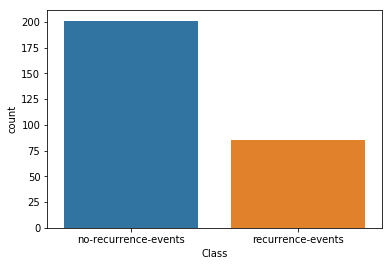

In [62]:
sns.countplot('Class',data=Breast_cancer)

What ages do we have in our data set? And is age related in any way with having 

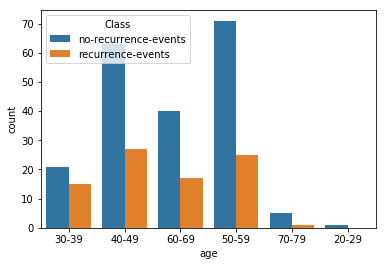

In [63]:
sns.countplot('age',hue='Class',data=Breast_cancer)

## Model Building

In [64]:
Breast_cancer.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


Let us separate x and y features.

### Feature Engineering

In [65]:
y = Breast_cancer['Class']
features = Breast_cancer.drop(['Class'],axis=1)

We notice except 'deg-malig' all the other variables are categorical. We need to convert them into numerical so that we can use it in the model. 

In [66]:
cat_cols = ['age','menopause','tumor-size','inv-nodes','node-caps','breast','breast-quad','irradiat']#
X = pd.get_dummies(features,columns=cat_cols)

### Logistic regressor with cross validation

In [80]:
#%%time
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

#specify k
k=10

KF = KFold(n_splits = k, shuffle = True, random_state=1)

train_accuracy=[]
for i,(train_ind, test_ind) in enumerate(KF.split(X)):
    print('========Fold',i)
    Xtrain, XCV, ytrain, yCV = X.iloc[train_ind], X.iloc[test_ind], y.values[train_ind], y.values[test_ind]
    
    #normalize the variables so that they are in same scale
    sc = StandardScaler()
    Xtrain = pd.DataFrame(sc.fit_transform(Xtrain))
    XCV = pd.DataFrame(sc.transform(XCV))
    
    #fit the model and predict
    regressor = LogisticRegression(C=0.01, solver='liblinear').fit(Xtrain, ytrain)
    pred = regressor.predict(XCV)
    
    #compute accuracy
    train_accuracy.append(metrics.accuracy_score(pred, yCV))
    
    print('Accuracy for fold',i, ' : ', metrics.accuracy_score(pred, yCV))
 
print('   ')
print(k,"-fold cross validation average accuracy: %.3f" % np.mean(train_accuracy))

========Fold 0
Accuracy for fold 0  :  0.7241379310344828
========Fold 1
Accuracy for fold 1  :  0.5862068965517241
========Fold 2
Accuracy for fold 2  :  0.7241379310344828
========Fold 3
Accuracy for fold 3  :  0.8275862068965517
========Fold 4
Accuracy for fold 4  :  0.7586206896551724
========Fold 5
Accuracy for fold 5  :  0.6551724137931034
========Fold 6
Accuracy for fold 6  :  0.75
========Fold 7
Accuracy for fold 7  :  0.7142857142857143
========Fold 8
Accuracy for fold 8  :  0.8214285714285714
========Fold 9
Accuracy for fold 9  :  0.6071428571428571
   
10 -fold cross validation average accuracy: 0.717
